In [1]:
%matplotlib inline


# Masked sifting
This tutorial introduces some of the issues that standard EMD algorithms can
have with intermitent signals and shows how the Masked sift can resolve them.


Lets make a simulated signal to get started.



Text(0.5, 0, 'Samples')

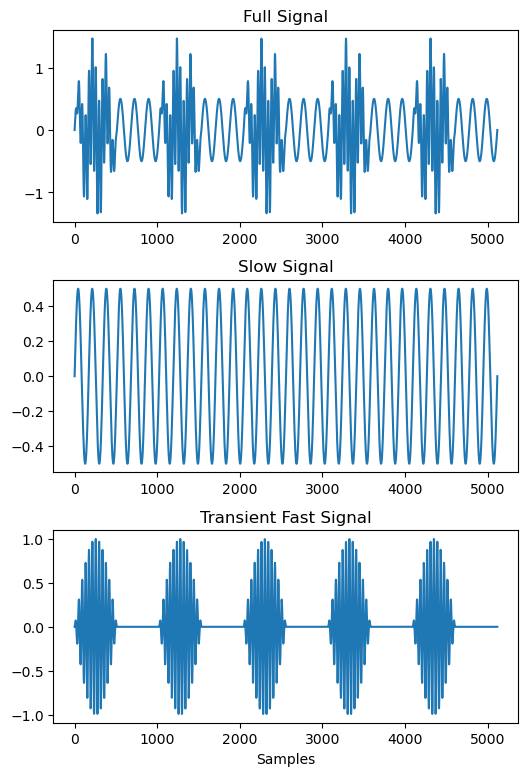

In [2]:
import emd
import numpy as np
import matplotlib.pyplot as plt

seconds = 5
sample_rate = 1024
time_vect = np.linspace(0, seconds, seconds*sample_rate)

# Create an amplitude modulation
am = np.sin(2*np.pi*time_vect)
am[am < 0] = 0

# Create a 25Hz signal and introduce the amplitude modulation
xx = am*np.sin(2*np.pi*25*time_vect)

# Create a non-modulated 6Hz signal
yy = .5*np.sin(2*np.pi*6*time_vect)

# Sum the 25Hz and 6Hz components together
xy = xx+yy

# Make a quick summary plot
plt.figure(figsize=(6,9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(xy)
plt.title('Full Signal')
plt.subplot(312)
plt.plot(yy)
plt.title('Slow Signal')
plt.subplot(313)
plt.plot(xx)
plt.title('Transient Fast Signal')
plt.xlabel('Samples')

# sphinx_gallery_thumbnail_number = 2

This signal doesn't contain any noise and only has two frequency components
so should be straightforward to sift. Unfortunately, as the 25Hz signal
component disappears completely for parts of the signal the EMD doesn't quite
do what we'd want it to.

Here we run a default sift and plot the IMFs.



<AxesSubplot:xlabel='Time (samples)'>

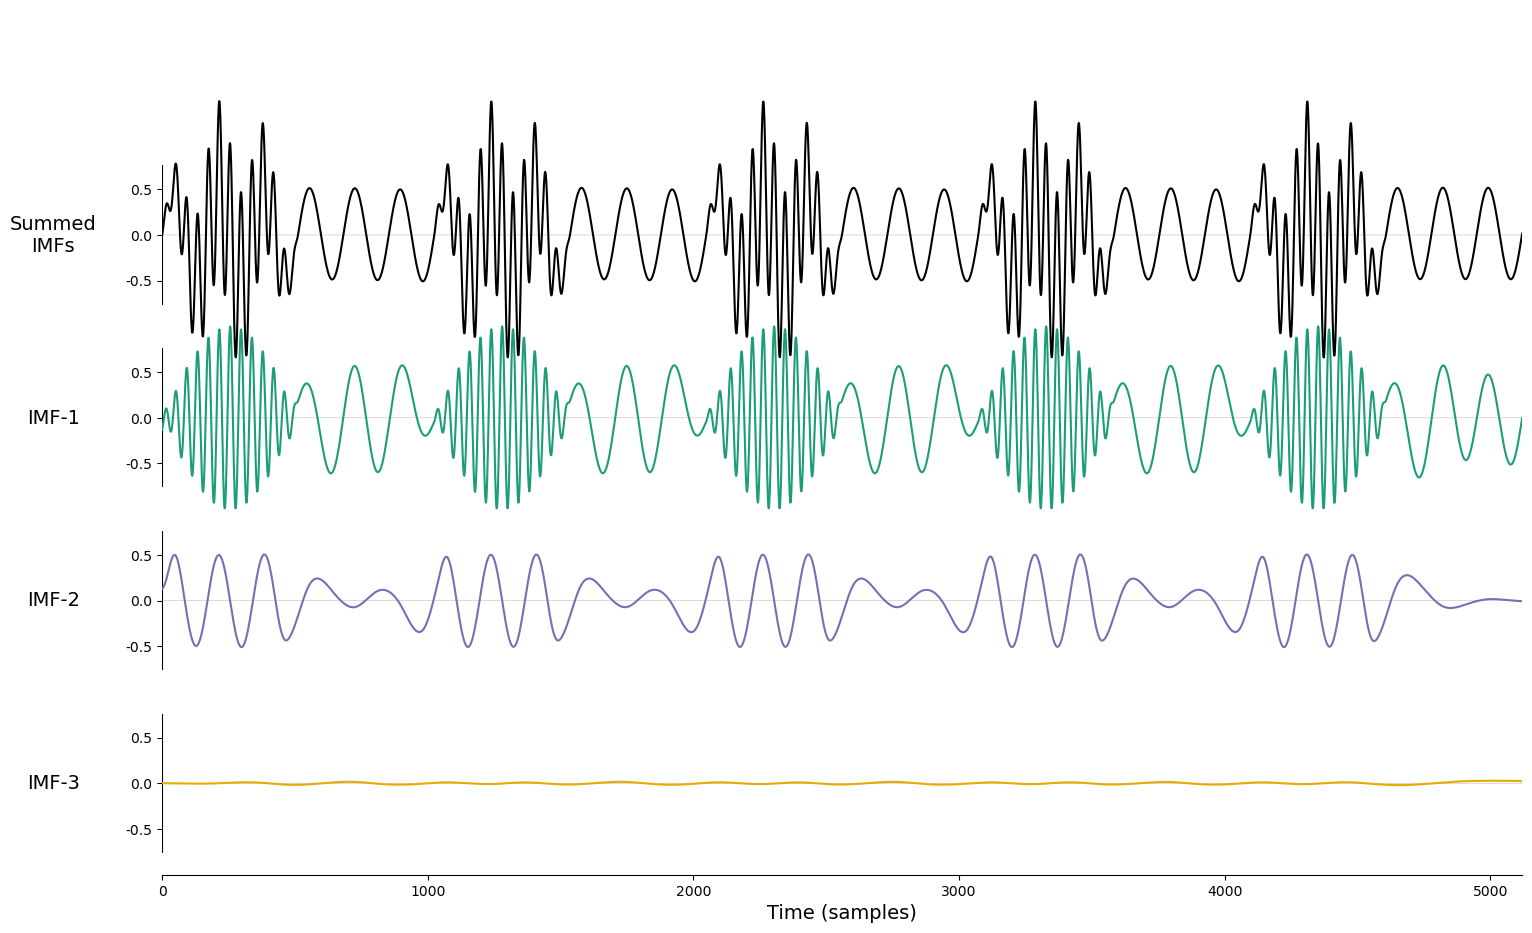

In [3]:
imf = emd.sift.sift(xy, max_imfs=3)
emd.plotting.plot_imfs(imf)

The signals are well separated when both oscillations are present. However in
time periods where the fast 25Hz signal disappears the slower signal jumps up
to become part of the fast component. We'd prefer the separation into narrow
band components as seen in the simulations above...

This happens as EMD is a locally adaptive algorithm - the peaks and troughs
in the signal define the time-scales that are analysed for a given part of
the signal. So, the first IMF will always find the fastest peaks for every
part of the signal even if the definition of 'fast' might be different in
different segments.

The masked sift is a potential solution to this problem. This is a simple
trick which effectively puts a lower bound on the frequency content that can
enter a particular IMF. We will add a known masking signal to our time-series
before running ``emd.sift.get_next_imf``. Any signals which are lower in
frequency than this mask should then be ignored by the sift in favour of this
known signal. Finally, we can remove the known mask to recover our IMF.




## Adding a single mask



Here we make a 30Hz mask and plot it next to a segment of our time-series.



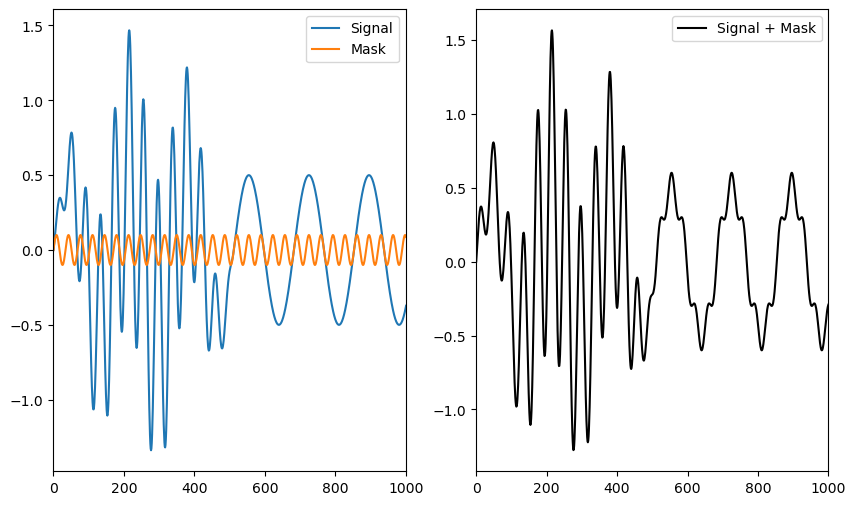

In [4]:
mask = 0.1*np.sin(2*np.pi*30*time_vect)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(xy)
plt.plot(mask)
plt.legend(['Signal', 'Mask'])
plt.xlim(0, 1000)
plt.subplot(122)
plt.plot(xy + mask, color='k')
plt.xlim(0, 1000)
plt.legend(['Signal + Mask'])

We see that the masking signal is close in frequency to the fast burst but
much faster than the 6Hz signal.

Next we identify our next IMF on the raw signal with and without the mask



In [5]:
imf_raw, _ = emd.sift.get_next_imf(xy)
imf_mask, _ = emd.sift.get_next_imf(xy+mask)

The normal IMF in the top panel has the problem we saw earlier, the slow
signal is leaking into the fast IMF. The masked IMF successfully suppresses
this slow signal, replacing it with the mask frequency. Finally, subtracting
the mask removes everything but the 25Hz oscillation which now correctly
disappears between bursts.



Text(0.5, 1.0, 'Masked IMF with Mask removed')

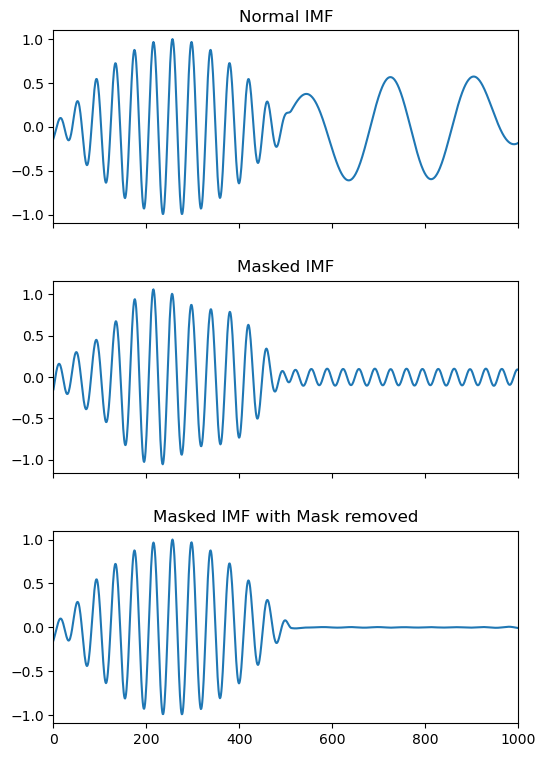

In [6]:
plt.figure(figsize=(6,9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(imf_raw)
plt.xlim(0, 1000)
plt.title('Normal IMF')
plt.gca().set_xticklabels([])
plt.subplot(312)
plt.plot(imf_mask)
plt.xlim(0, 1000)
plt.title('Masked IMF')
plt.gca().set_xticklabels([])
plt.subplot(313)
plt.plot(imf_mask - mask[:, np.newaxis])
plt.xlim(0, 1000)
plt.title('Masked IMF with Mask removed')

This effect is more obvious if we look at the whole time-courses without zooming in



Text(0.5, 1.0, 'Masked IMF with Mask removed')

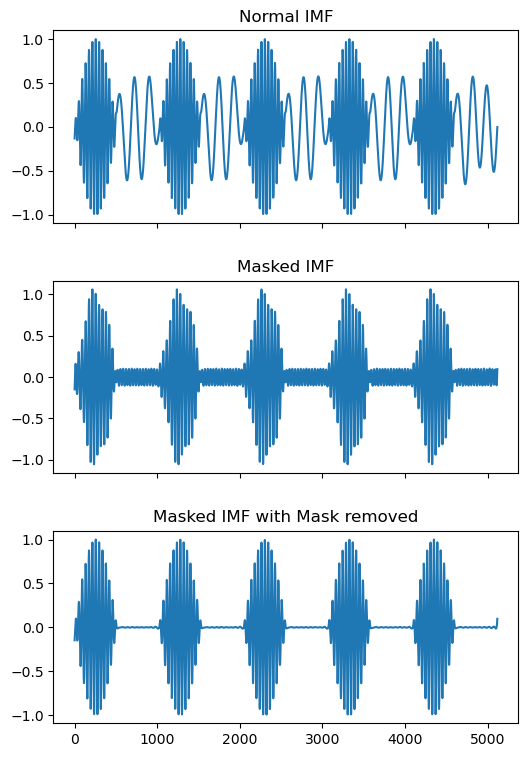

In [7]:
plt.figure(figsize=(6, 9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(imf_raw)
plt.title('Normal IMF')
plt.gca().set_xticklabels([])
plt.subplot(312)
plt.plot(imf_mask)
plt.title('Masked IMF')
plt.gca().set_xticklabels([])
plt.subplot(313)
plt.plot(imf_mask - mask[:, np.newaxis])
plt.title('Masked IMF with Mask removed')

This masking process is implemented in ``emd.sift.get_next_imf_mask`` which
works much like ``emd.sift.get_next_imf`` with a couple of extra options for
adding masks. We can specify the frequency and amplitude of the mask to be
applied whilst isolating our IMF.




## Choosing mask frequency



It is important that the mask frequency is approximately equal to the signal
component we want to isolate. If we use a mask of too high or too low
frequency then the procedure will not work.

Here we apply a range of masks to illustrate this effect. We apply a high
frequency mask, a low frequency mask and a 'just-right' mask close to the
30Hz signal.



Text(0.5, 1.0, '2Hz mask - too low')

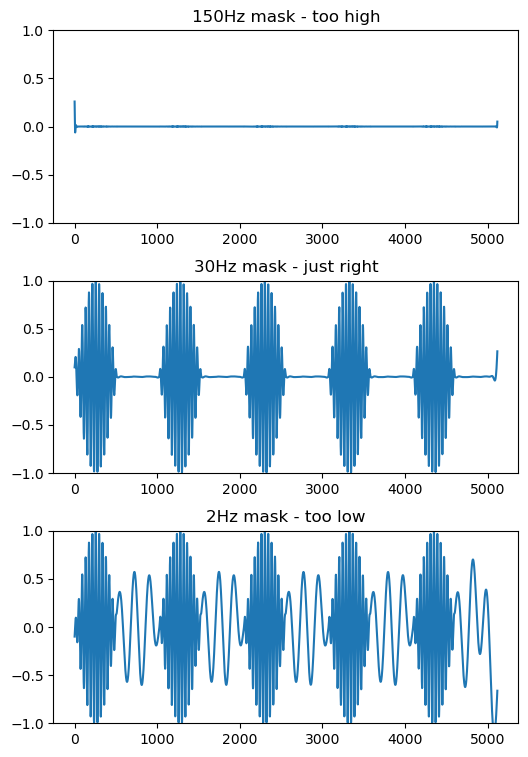

In [8]:
# Masks should be specified in normalised frequencies between 0 and .5 where 0.5 is half the sampling rate
high_mask_freq = 150/sample_rate
imf_high_mask, _ = emd.sift.get_next_imf_mask(xy, high_mask_freq, 2)

med_mask_freq = 30/sample_rate
imf_med_mask, _ = emd.sift.get_next_imf_mask(xy, med_mask_freq, 2)

low_mask_freq = 2/sample_rate
imf_low_mask, _ = emd.sift.get_next_imf_mask(xy, low_mask_freq, 2)

plt.figure(figsize=(6, 9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(imf_high_mask)
plt.title('150Hz mask - too high')
plt.ylim(-1, 1)
plt.subplot(312)
plt.plot(imf_med_mask)
plt.ylim(-1, 1)
plt.title('30Hz mask - just right')
plt.subplot(313)
plt.plot(imf_low_mask)
plt.ylim(-1, 1)
plt.title('2Hz mask - too low')

We can see that the high frequency mask has suppressed both signal components
whist the low frequency mask has allowed them both through. In contrast, when
the mask frequency is closest to the fastest dynamics present in the signal -
it is able to successfully isolate them.



Choosing a mask frequency may not be so simple in real data applications
where multiple signal components may be present alongside measurement noise.
We recommend a rule-of-thumb based on simulations in Fosso & Molinas 2017
(http://arxiv.org/abs/1709.05547). A given mask with frequency f Hz, can be
expected to remove frequencies below  0.7*f Hz. As an example, a mask with
frequency 50Hz will keep oscillatory content of 40Hz but remove content of
30Hz.

The flexibility provided by masked sifting overcomes several issue with
conventional sifting but this flexibility can also lead to problems. If you do
use a highly tuned set of masks for an analysis, we recommend careful
checking of the IMFs before proceeding to the main analysis. You should
ensure that the IMFs are well separated - the components should have low
correlations/orthogonality scores - and that the instantaneous frequency
content of the IMFs do not strongly overlap.



## Running a full mask sift



Until now, we've only been separating two signals with a single pass of the
sift. ``emd.sift.mask_sift`` uses ``emd.sift.get_next_imf_mask`` internally
to run a whole set of sifts using the masking method. Each IMF is isolated
with a separate mask which decreases in frequency for each successive IMF.

Here we run a ``mask_sift`` using mask frequencies starting at 30Hz. This
will reduce by one half for each successive IMF - the second mask will be
15Hz, the third is 7.5Hz and so on.



In [9]:
imf, mask_freqs = emd.sift.mask_sift(xy, mask_freqs=30/sample_rate, ret_mask_freq=True, max_imfs=4)

print(mask_freqs * sample_rate)

[30.   15.    7.5   3.75]


We can see that this sift nicely separates the two components. The first IMF
contains the 25Hz bursting signal which returns to a flat line between
events. The second IMF contains very low amplitude noise. This is as the mask
frequency of 15Hz for the second mask is still too high to isolate the
oscillation of 6Hz - so IMF 2 is essentially flat. The third IMF with a mask
frequency of 7.5Hz is about right to isolate the 6Hz signal.



<AxesSubplot:xlabel='Time (samples)'>

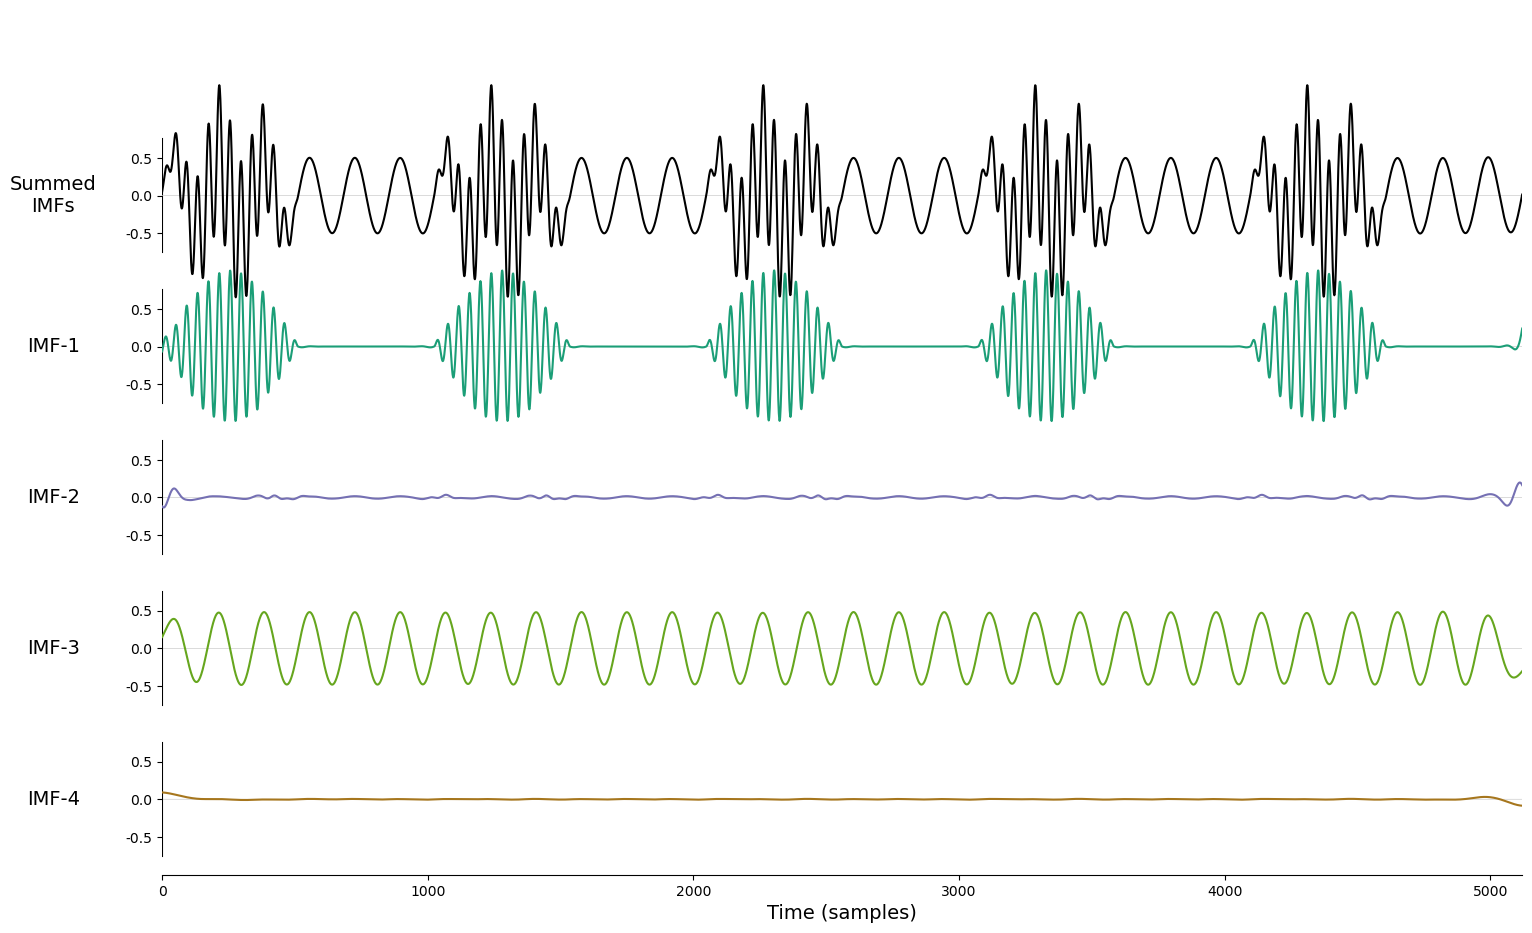

In [10]:
emd.plotting.plot_imfs(imf)

## Further Reading & References



Deering R, Kaiser JF (2005)
The use of a masking signal to improve empirical mode decomposition.
IEEE International Conference on Acoustics, Speech, and Signal Processing. vol. 4. p. iv/485–iv/488.
https://doi.org/10.1109/ICASSP.2005.1416051.

Andrew J. Quinn, Vítor Lopes-dos-Santos, Norden Huang, Wei-Kuang Liang, Chi-Hung Juan, Jia-Rong Yeh, Anna C. Nobre, David Dupret, and Mark W. Woolrich (2001)
Within-cycle instantaneous frequency profiles report oscillatory waveform dynamics
Journal of Neurophysiology 126:4, 1190-1208
https://doi.org/10.1152/jn.00201.2021

